# Left egocentric neglect sanity check

In [2]:
import sys
import numpy as np
from scipy.stats import ttest_ind
import nibabel as nib
sys.path.append("../code/")

## Traditional VLSM

553it [00:45, 12.23it/s]
/home/lukeh/miniconda3/envs/NegNets/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/lukeh/miniconda3/envs/NegNets/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


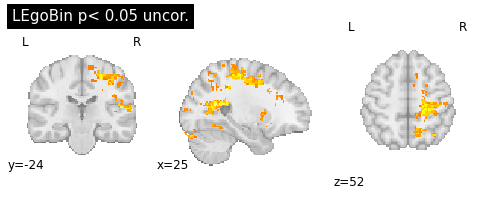

In [3]:
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import new_img_like
import seaborn as sns
from data_helpers import load_lesions, get_phenotype

# whether to perform dtlvc lesion correction method
dtlvc = True
df = get_phenotype()

# load lesion maps
map_array = load_lesions(df, label='resampled_lesion_file', dtlvc=dtlvc)

# split groups based on LEgoBin
a = map_array[df.LEgoBin.values == 1, :]
b = map_array[df.LEgoBin.values == 0, :]
t, p = ttest_ind(a, b, axis=0, equal_var=False, alternative='greater')

# create some plots
tmp = nib.load(df['resampled_lesion_file'][0])
t_img = t.reshape(tmp.shape)
p_img = p.reshape(tmp.shape)
t_img[p_img > 0.05] = 0
img = new_img_like(tmp, t_img)
plotting.plot_stat_map(img, draw_cross=False, title='LEgoBin p< 0.05 uncor.', colorbar=False)
plotting.show()

## 'Parcel' LSM

100%|██████████| 442/442 [00:10<00:00, 43.68it/s]


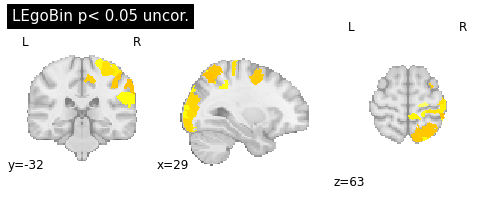

387


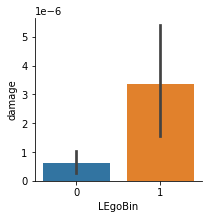

In [4]:
from data_helpers import load_parcel_dmg, vec_to_img
# whether to normalise the data by the size of the parcels
# (shouldn't make much difference)
norm = True

# parcellation to use
parc = 'Schaefer_400_Tian_1_AAL'

# lesion size control
dtlvc = True

df = get_phenotype(parc=parc,
                   normalised=norm,
                   clean_df=True)

gm_dmg = load_parcel_dmg(df,
                         parc=parc,
                         normalised=norm,
                         dtlvc=dtlvc)

# split groups based on LEgoBin
a = gm_dmg[df.LEgoBin.values == 1, :]
b = gm_dmg[df.LEgoBin.values != 1, :]

t, p = ttest_ind(a, b, equal_var=False, alternative='greater')

# create some plots
# transpose t to brain space and plot
t[p > 0.05] = 0
img = vec_to_img(t, parc=parc)
plotting.plot_stat_map(img, draw_cross=False, title='LEgoBin p< 0.05 uncor.', colorbar=False)
plotting.show()

# plot a single ROI to double check
idx = np.where(p == np.min(p))[0][0]
print(idx)
plot_df = df.copy()
plot_df['damage'] = gm_dmg[:, idx]
plt.figure(figsize=(3,3))
sns.barplot(data=plot_df, y='damage', x='LEgoBin')
sns.despine()
plt.show()

## Connectivity LSM

553it [00:01, 496.89it/s]


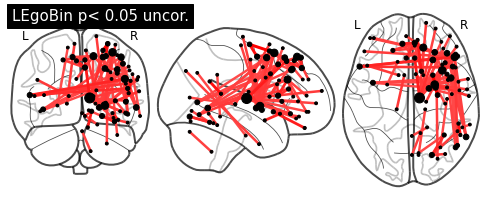

In [5]:
from data_helpers import load_conn_dmg, vec_to_mat, get_coords
norm = True
parc = 'Schaefer_400_Tian_1_AAL'
dtlvc = True

df = get_phenotype(parc=parc,
                   normalised=norm,
                   clean_df=True)

conn_dmg = load_conn_dmg(df,
                       dtlvc=dtlvc)

# split groups based on LEgoBin
a = conn_dmg[df.LEgoBin.values == 1, :]
b = conn_dmg[df.LEgoBin.values != 1, :]

t, p = ttest_ind(a, b, equal_var=False, alternative='greater')

# create a basic plot
t[np.isnan(t)] = 0
t[p > 0.05] = 0
cm = vec_to_mat(t)

# get MNI coordinates...
coords = get_coords(parc)


degree = np.sum(abs(cm), axis=1)
degree_plot = (degree / np.max(degree)) * 100
plotting.plot_connectome(cm, coords, node_size=degree_plot,
                         node_color='k', title='LEgoBin p< 0.05 uncor.')
plotting.show()